<a href="https://colab.research.google.com/github/paulorfbr/deepReinforcementLearning/blob/mountain-car/OpenGym_MountainCar_TD_lambda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym

In [2]:
# Adapt Q-Learning script to use TD(lambda) method instead

import gym
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from gym import wrappers
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor

In [3]:
# Inspired by https://github.com/dennybritz/reinforcement-learning
class FeatureTransformer:
  def __init__(self, env, n_components=500):
    observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
    scaler = StandardScaler()
    scaler.fit(observation_examples)

    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
            ])
    example_features = featurizer.fit_transform(scaler.transform(observation_examples))

    self.dimensions = example_features.shape[1]
    self.scaler = scaler
    self.featurizer = featurizer

  def transform(self, observations):
    # print "observations:", observations
    scaled = self.scaler.transform(observations)
    # assert(len(scaled.shape) == 2)
    return self.featurizer.transform(scaled)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def plot_cost_to_go(env, estimator, num_tiles=20):
  x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
  y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
  X, Y = np.meshgrid(x, y)
  # both X and Y will be of shape (num_tiles, num_tiles)
  Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))
  # Z will also be of shape (num_tiles, num_tiles)

  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111, projection='3d')
  surf = ax.plot_surface(X, Y, Z,
    rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
  ax.set_xlabel('Position')
  ax.set_ylabel('Velocity')
  ax.set_zlabel('Cost-To-Go == -V(s)')
  ax.set_title("Cost-To-Go Function")
  fig.colorbar(surf)
  plt.show()


def plot_running_avg(totalrewards):
  N = len(totalrewards)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
  plt.plot(running_avg)
  plt.title("Running Average")
  plt.show()

In [5]:
class BaseModel:
  def __init__(self, D):
    self.w = np.random.randn(D) / np.sqrt(D)

  def partial_fit(self, input_, target, eligibility, lr=1e-2):
    self.w += lr*(target - input_.dot(self.w))*eligibility

  def predict(self, X):
    X = np.array(X)
    return X.dot(self.w)

In [6]:
# Holds one BaseModel for each action
class Model:
  def __init__(self, env, feature_transformer):
    self.env = env
    self.models = []
    self.feature_transformer = feature_transformer

    D = feature_transformer.dimensions
    self.eligibilities = np.zeros((env.action_space.n, D))
    for i in range(env.action_space.n):
      model = BaseModel(D)
      self.models.append(model)

  def predict(self, s):
    X = self.feature_transformer.transform([s])
    assert(len(X.shape) == 2)
    result = np.stack([m.predict(X) for m in self.models]).T
    assert(len(result.shape) == 2)
    return result

  def update(self, s, a, G, gamma, lambda_):
    X = self.feature_transformer.transform([s])
    assert(len(X.shape) == 2)
    self.eligibilities *= gamma*lambda_
    self.eligibilities[a] += X[0]
    self.models[a].partial_fit(X[0], G, self.eligibilities[a])

  def sample_action(self, s, eps):
    if np.random.random() < eps:
      return self.env.action_space.sample()
    else:
      return np.argmax(self.predict(s))

In [7]:
# returns a list of states_and_rewards, and the total reward
def play_one(model, env, eps, gamma, lambda_):
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0
  # while not done and iters < 200:
  while not done and iters < 1000:
    action = model.sample_action(observation, eps)
    prev_observation = observation
    observation, reward, done, info = env.step(action)

    # update the model
    next = model.predict(observation)
    assert(next.shape == (1, env.action_space.n))
    G = reward + gamma*np.max(next[0])
    model.update(prev_observation, action, G, gamma, lambda_)

    totalreward += reward
    iters += 1

  return totalreward


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initi

avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initi

avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277
avg reward for last 100 episodes: 2.978668005742653e+260
tot

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.805265351355748e+277


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initi

avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.97866800574265

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initi

avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -1.8052653513557478e+277
avg reward for last 100 episodes: 2.97866800574265

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -7.861874026973908e+276


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initi

avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -7.861874026973908e+276
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -7.861874026973908e+276
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -7.861874026973908e+276
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -7.861874026973908e+276
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -7.861874026973908e+276
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -7.861874026973908e+276
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -7.861874026973908e+276
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -7.861874026907603e+276
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -7.861874026907603e+276
avg reward for last 100 episodes: 2.978668005742653e+260
total steps: -7.861874026907603e+276
avg reward for last 100 episodes: 2.978668005742653e+260
tot

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment ini

avg reward for last 100 episodes: 1.686302543780334e+251
total steps: -1.6863025437803338e+253


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initi

avg reward for last 100 episodes: 1.686302543780334e+251
total steps: -1.6863025437803338e+253
avg reward for last 100 episodes: 1.686302543780334e+251
total steps: -1.6863025437803338e+253
avg reward for last 100 episodes: 1.686302543780334e+251
total steps: -1.6863025437803338e+253
avg reward for last 100 episodes: 1.686302543780334e+251
total steps: -1.6863025437803338e+253
avg reward for last 100 episodes: 1.686302543780334e+251
total steps: -1.6863025437803338e+253
avg reward for last 100 episodes: 1.686302543780334e+251
total steps: -1.6863025437803338e+253
avg reward for last 100 episodes: 1.686302543780334e+251
total steps: -1.6863025437803338e+253
avg reward for last 100 episodes: 1.686302543780334e+251
total steps: -1.6863025437803338e+253
avg reward for last 100 episodes: 1.686302543780334e+251
total steps: -1.6863025437803338e+253
avg reward for last 100 episodes: 1.686302543780334e+251
total steps: -1.6863025437803338e+253
avg reward for last 100 episodes: 1.68630254378033

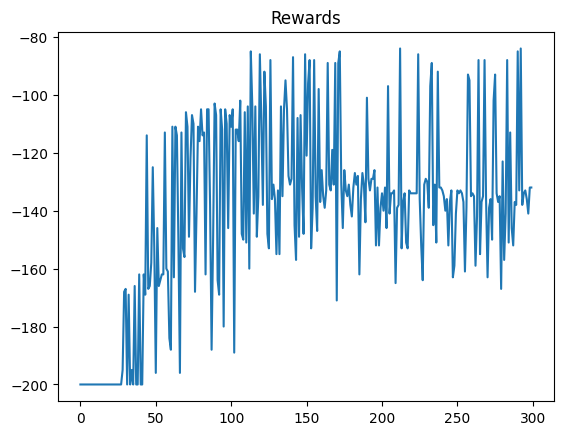

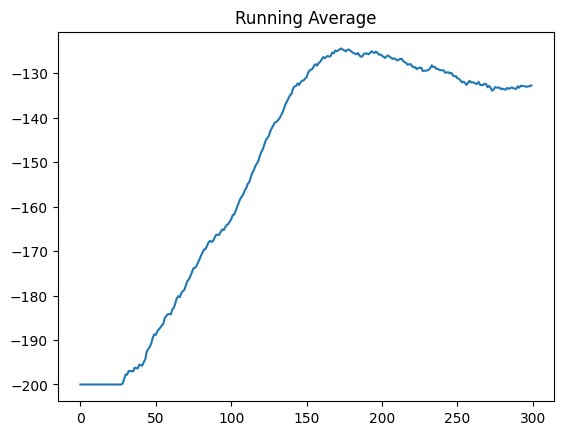

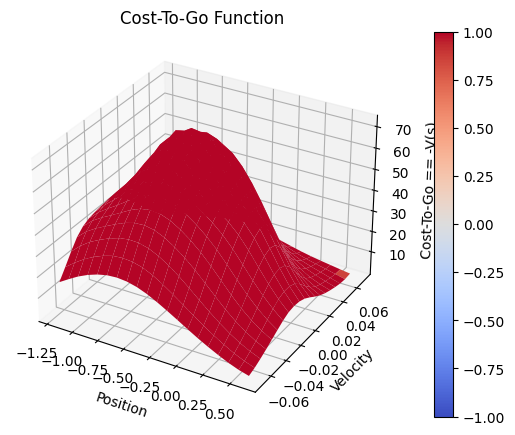

In [9]:
env = gym.make('MountainCar-v0')
ft = FeatureTransformer(env)
model = Model(env, ft)
gamma = 0.99
lambda_ = 0.7

filename = 'mountain-car'
monitor_dir = './' + filename + '_' + str(datetime.now())
env = wrappers.RecordVideo(env, filename)

show_plots = True
N = 300
totalrewards = np.empty(N)
for n in range(N):
  # eps = 1.0/(0.1*n+1)
  eps = 0.1*(0.97**n)
  if n == 199:
    print("eps:", eps)
  # eps = 1.0/np.sqrt(n+1)
  totalreward = play_one(model, env, eps, gamma, lambda_)
  totalrewards[n] = totalreward
  if (n + 1) % 100 == 0:
    print("episode:", n, "total reward:", totalreward)
  print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
  print("total steps:", -totalrewards.sum())

if show_plots:
  plt.plot(totalrewards)
  plt.title("Rewards")
  plt.show()

  plot_running_avg(totalrewards)

  # plot the optimal state-value function
  plot_cost_to_go(env, model)